# Import dependencies

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from utils.data.load_root import load_root
from utils.data.build_graph import build_graphs
from utils.data.load_graphs import load_graphs
from utils.evaluation.evaluate_graphs import evaluate_data, evaluate_graphs
from utils.plotting.plot_events import plot_information, plot_event
from utils.data.graphdata import GraphDataset
from utils.models.interaction_network import InteractionNetwork
from utils.training.train_3 import train_model
from utils.evaluation.evaluate_model import evaluate_model


# Import Root data

In [2]:
%%time
load_rootdata = False

if load_rootdata:
    path = "~/Documents/Masterarbeit/Panda_Software/PandaRoot/dev/source/macro/data/evtcomplete"
    raw = load_root(path, showentries=True)
    raw.to_hdf('data/raw.h5', key='df', mode='w')  

else:
    raw = pd.read_hdf('data/raw.h5', 'df')  

CPU times: user 138 ms, sys: 101 ms, total: 239 ms
Wall time: 248 ms


In [3]:
raw

,hit_id,x,z,iso,pz,chamber_id,skewed,particle_id,layer_id
event_id,,,,,,,,,
0,0,-15.907500,606.994995,0.453287,2.604892,5,0,5,33
0,1,-15.402500,607.869690,0.168081,2.604809,5,0,5,34
0,2,-15.967299,611.489990,0.338337,2.604617,5,1,5,35
0,3,-15.460370,612.364685,0.275247,2.604552,5,1,5,36
0,4,-16.981157,616.489990,0.066004,2.604429,5,1,5,37
...,...,...,...,...,...,...,...,...,...
29999,236,5.683260,644.364685,0.086834,7.105113,6,1,0,44
29999,237,4.457249,648.489990,0.159684,7.105056,6,1,0,45
29999,238,3.950320,649.364685,0.385276,7.104989,6,1,0,46


Choose number of events to be analysed

In [4]:
nevents = raw.index.max()
nevents = 100
node_dim = 3
edge_dim = 3

# Investigate raw data

In [5]:
%%time

show=False
if show:
   
    plot_information(raw).plot_ntracks_nhits()
    evID=np.random.randint(nevents)
    evID = 3
    event = raw.loc[raw.index==evID]
    plot_event(event, scale=1.8).plot_eventdisplay()
    
    data_eval = evaluate_data(raw, ncuts=50)
    data_eval.curler_dist()

    purity, efficiency, cuts, cutPos, TNR, FNR = data_eval.find_pzcut()
    data = plot_information()
    data.plot_purity_efficiency(cuts, 25, purity, efficiency, TNR, FNR, variable = r'$p_z$', xname = r'$p_z$ threshold (GeV)', yname = 'purity & efficiency', save_name = 'img/3_pz_threshold.pdf')


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


# Graph building for training

In [24]:
%%time
in_dir = 'data/graphs'
data = build_graphs(raw,end=nevents, shuffle=True,  pz_min=0.003, remove_duplicates=True, slope=5.)

create_g = False

if create_g:
    graphs = data.create_graph_list(node_dim=3, edge_dim=3,minlayer=0, maxlayer=24)
    targets = []

    data_paths = [i for i in (os.path.join(in_dir, f) for f in os.listdir(in_dir)) if os.path.isfile(i)]
    for f in data_paths:
        os.remove(f)

    for graph in graphs:
        evID = graph.pid.index.unique()[0]
        x, edge_attr, edge_index, y, pid = graph
        targets.append(y)
        arr = np.asanyarray([x, edge_attr, edge_index, y, pid], dtype=object)
        np.save(f'{in_dir}/graph_{evID}.npy', arr)
    print(f'graphs saved to {in_dir}')

    targets = np.concatenate(targets)
    print(f'signal fraction true/all edges: {np.sum(targets)/len(targets)}')

else:
    graphs = load_graphs(in_dir, nevents, node_dim, edge_dim)

#show preprocessed data
data.events.sort_index()

CPU times: user 116 ms, sys: 40 ms, total: 156 ms
Wall time: 155 ms


,hit_id,particle_id,x,z,iso,pz,chamber_id,skewed,layer_id,layer,Hit_id
event_id,,,,,,,,,,,
0,5266,4,11.867500,310.264679,0.417781,5.257255,1,0,8,4,29
0,1542,0,19.442499,326.894989,0.259519,2.432260,2,0,9,5,205
0,6863,3,-11.867500,341.390015,0.327790,7.724906,2,0,15,7,83
0,9265,3,-9.847500,309.390015,0.441207,7.725171,1,0,7,3,75
0,3062,3,-28.532499,607.869690,0.216925,7.701199,5,0,34,18,86
...,...,...,...,...,...,...,...,...,...,...,...
100,3775,5,67.922501,638.994995,0.336665,3.175205,6,0,41,21,40
100,8013,2,39.642502,466.964996,0.269347,2.196668,4,0,31,15,175
100,6986,0,-98.222504,622.364685,0.459414,9.606865,5,0,40,20,232


# Evaluate Graph building
for comparison with original raw data choose evaluate_graphs(data.raw.rename(columns={'layer_id':'layer'}), graphs).evaluate_graphs()

In [22]:
%%time
evaluate_gb = False

if evaluate_gb:
        
    testdata = build_graphs(raw,end=1000, shuffle=True, remove_duplicates=False)
#     ncuts = 100
#     slope = np.linspace(0.1,4,ncuts)
#     purities, efficiencies, TNRs, FNRs = np.zeros((4,ncuts))
    
    
#     for i, s in enumerate(tqdm(slope)):
#         testdata.slope = s
#         testgraphs = testdata.create_graph_list(show_progress=False, node_dim=3, edge_dim=3)
#         purity, efficiency, TNR, FNR, _ = evaluate_graphs(testdata.events, testgraphs).evaluate_graphs(show_progress=False)
#         purities[i] = purity
#         efficiencies[i] = efficiency
#         TNRs[i] = TNR
#         FNRs[i] = FNR
        
#     plot_information().plot_purity_efficiency(slope, 13, purities, efficiencies, TNRs, FNRs, 'slope', 'slope threshold', 'purity & efficiency', 'img/3_graphbuilding_purity_efficiency.pdf')
    
    nnodes = []
    nedges = []

    sslope = [0.1, 0.6, 1., 2., 4.]
    for i, s in enumerate(tqdm(sslope)):
        testdata.slope = s
        testgraphs = testdata.create_graph_list(show_progress=False, node_dim=3, edge_dim=3)
        ne = []
        for g in testgraphs:
            ne.append(len(g.y))
        nedges.append(ne)
        
    for g in testgraphs:
        nnodes.append(len(g.x))
        
    show_infos = plot_information(graphs=graphs)
#     show_infos.plot_graph_data_info()
    
    show_infos.plot_graph_dimensions(nnodes, nedges, sslope)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs


# Plot Graphs

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils.plotting.plot import watermark
from utils.data.graphdata import GraphDataset
class plot_event:
    
    def __init__(self, event=None, graph=None, scale=1.4, shift=0.13):
        self.event = event
        self.graph = graph
        self.scale = scale
        self.shift = shift
        
    def __plot_display(self, name, title=None, xlabel='z (cm)', ylabel='x (cm)', py=0.9, fontsize=18):
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(loc='upper right', frameon = True, framealpha = 0.8, facecolor = 'white', edgecolor = 'white', fontsize=12)
        watermark(py=py, fontsize=fontsize,  shift=self.shift, scale=self.scale)
        plt.text(s=title, x=0.033, y=0.83, ha='left', transform=plt.gca().transAxes, fontsize=16)
        plt.savefig(name)
        plt.show()
        

    def plot_eventdisplay(self):
        '''
        A method to plot one event in the 'x-z' projection for event ID: evID
        '''
        plt.style.use("kit")
        event = self.event
        ids = np.unique(event.particle_id)
        evID = event.index.unique()[0]

        plt.figure(figsize=(10,6))
        for ID in ids:
            df = event.loc[event.particle_id==ID]
            plt.scatter(df.z, df.x, s=df.iso*200, marker=r'$\odot$', linestyle='None', label=f'MC particle {ID:.0f}')
        self.__plot_display('img/3_rawdata_event.pdf', f'event ID = {evID}')
        
        
    def plot_graphdisplay(self):
        '''
        A method to plot one graph in the 'x-z' projection for event ID: evID
        '''
        segments = self.graph.edge_index
        segments = np.stack((segments[0], segments[1]), axis=1)

        X = np.array(self.graph.x)
        y = np.array(self.graph.y)
        evID = self.graph.pid.index.unique()[0]
        plt.style.use("kit")
        plt.figure(figsize=(10,6))

        for seg in segments:
            id1, id2 = seg
            if self.graph.x.shape == 4:
                x,z,theta,iso = np.vstack((X[int(id1)], X[int(id2)])).T
            else:
                x,z,theta = np.vstack((X[int(id1)], X[int(id2)])).T
                
            plt.plot(z*100, x*10, linewidth=1.0, linestyle='-', marker='None', color='black') 


        ids = np.unique(self.graph.pid)    
        for ID in ids:
            if self.graph.x.shape == 4:
                x,z,_, iso = X[self.graph.pid==ID].T
            else:
                x,z,_ = X[self.graph.pid==ID].T 
                
            plt.plot(z*100, x*10, linestyle='None', label=f'MC particle {ID:.0f}')
        self.__plot_display('img/3_graph_event.pdf', f'event ID = {evID}')

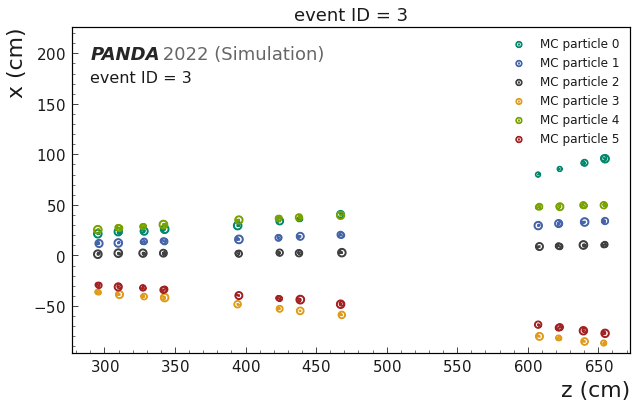

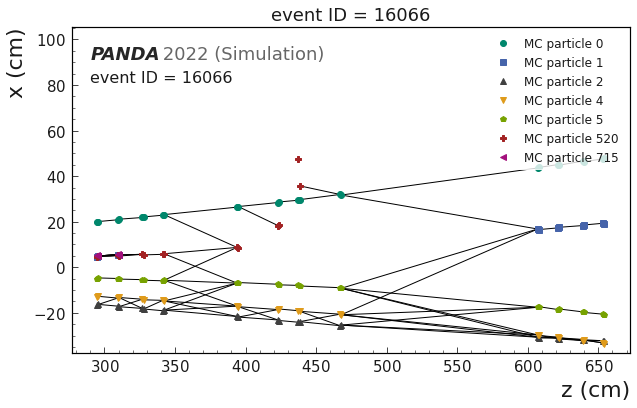

CPU times: user 1.38 s, sys: 236 ms, total: 1.62 s
Wall time: 1.32 s


In [42]:
%%time
evID = np.random.randint(nevents)
evID = 3

hits = data.events.loc[evID]
graph = graphs[evID]

plotevent = plot_event(hits, graph=graph, shift=.12, scale=1.6)
plotevent.plot_eventdisplay()
plotevent.plot_graphdisplay()


# Prepare Training

In [12]:
# torch.manual_seed(42)
device = 'cpu'
hidden_size = 8
name = f'IN_trained_{nevents}_neurons_{hidden_size}'
lr = 0.01
gamma = 0.7
epochs = 60
patience = 5
step_size = 3
batch_size = 1


parts = [0.8, 0.1, 0.1] #sizes of training, validation and testing samples
load_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 8}

In [13]:
parts = np.cumsum((nevents*np.array(parts)).astype(int))
partition = {'train': graphs[:parts[0]],  
             'test':  graphs[parts[0]:parts[1]],
             'val': graphs[parts[1]:parts[2]]}


train_set = GraphDataset(partition['train'])
train_loader = DataLoader(train_set, **load_params)
test_set = GraphDataset(partition['test'])
test_loader = DataLoader(test_set, **load_params)
val_set = GraphDataset(partition['val'])
val_loader = DataLoader(val_set, **load_params)

In [14]:
model = InteractionNetwork(hidden_size=hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

model.count_parameters()

InteractionNetwork(node_dim: 3, edge_dim: 3, hidden_size: 8)
+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
| R1.layers.0.weight |     72     |
|  R1.layers.0.bias  |     8      |
| R1.layers.2.weight |     64     |
|  R1.layers.2.bias  |     8      |
| R1.layers.4.weight |     24     |
|  R1.layers.4.bias  |     3      |
| O.layers.0.weight  |     48     |
|  O.layers.0.bias   |     8      |
| O.layers.2.weight  |     64     |
|  O.layers.2.bias   |     8      |
| O.layers.4.weight  |     24     |
|  O.layers.4.bias   |     3      |
| R2.layers.0.weight |     72     |
|  R2.layers.0.bias  |     8      |
| R2.layers.2.weight |     64     |
|  R2.layers.2.bias  |     8      |
| R2.layers.4.weight |     8      |
|  R2.layers.4.bias  |     1      |
+--------------------+------------+
Total Trainable Params: 495


# Training

In [15]:
results = train_model(train_loader, val_loader, model, optimizer, scheduler, epochs=epochs, patience=patience, name=name)

  0%|                                                    | 0/60 [00:00<?, ?it/s]

Train Epoch: 1, epoch time: 0.81s
Mean Train Batch Loss: 0.5321


  2%|▋                                           | 1/60 [00:01<01:01,  1.05s/it]


 Validation set: Average loss: 0.0675
, Accuracy: 0.7895

Validation loss decreased (inf --> 0.462080).  Saving model ...
Train Epoch: 2, epoch time: 0.70s
Mean Train Batch Loss: 0.2964


  3%|█▍                                          | 2/60 [00:01<00:56,  1.02it/s]


 Validation set: Average loss: 0.0290
, Accuracy: 0.8629

Validation loss decreased (0.462080 --> 0.325845).  Saving model ...
Train Epoch: 3, epoch time: 0.72s
Mean Train Batch Loss: 0.2562


  5%|██▏                                         | 3/60 [00:02<00:54,  1.04it/s]


 Validation set: Average loss: 0.0244
, Accuracy: 0.8816

Validation loss decreased (0.325845 --> 0.296685).  Saving model ...
Train Epoch: 4, epoch time: 0.70s
Mean Train Batch Loss: 0.2395


  5%|██▏                                         | 3/60 [00:03<01:11,  1.26s/it]


KeyboardInterrupt: 

In [63]:
model, losses, accs, test_losses, test_accs = results.trained

# Evaluate Training

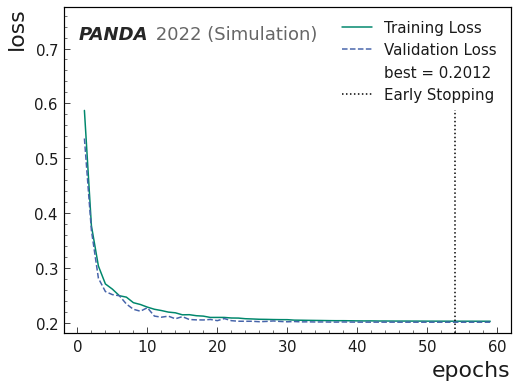

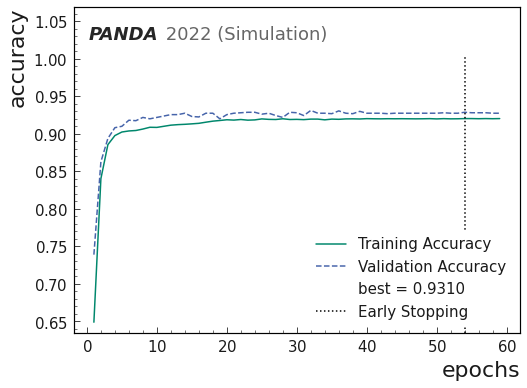

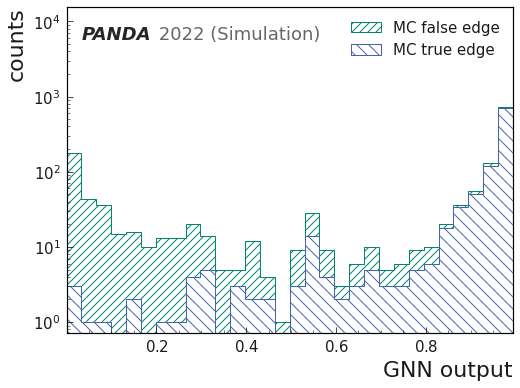

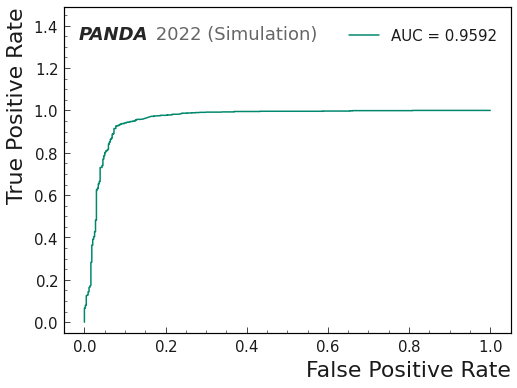

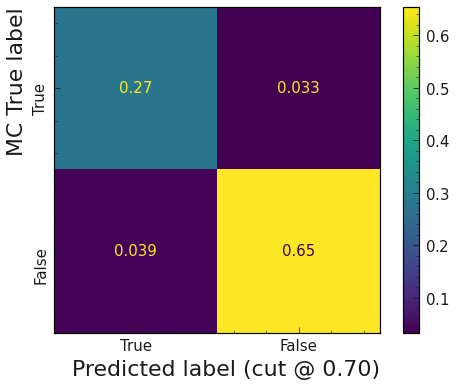

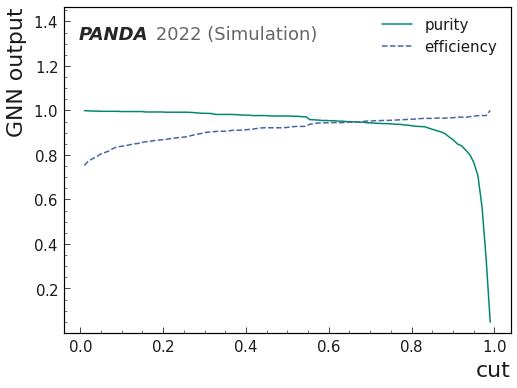

In [57]:
threshold = 0.7
evaluation = evaluate_model(model, test_loader, losses, test_losses, accs, test_accs, threshold, ncuts=100)
evaluation.plot_loss()
evaluation.plot_acc()
evaluation.plot_metrics()

# Show Results

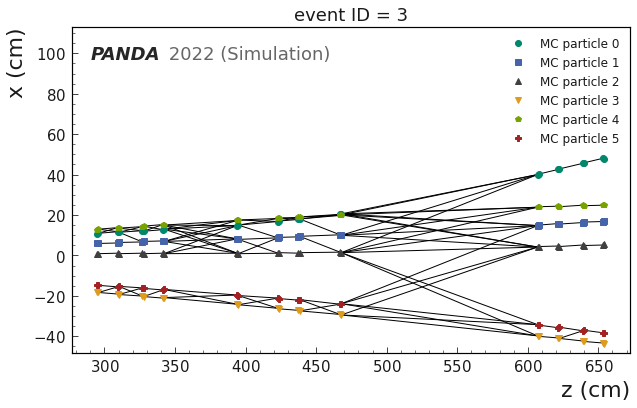

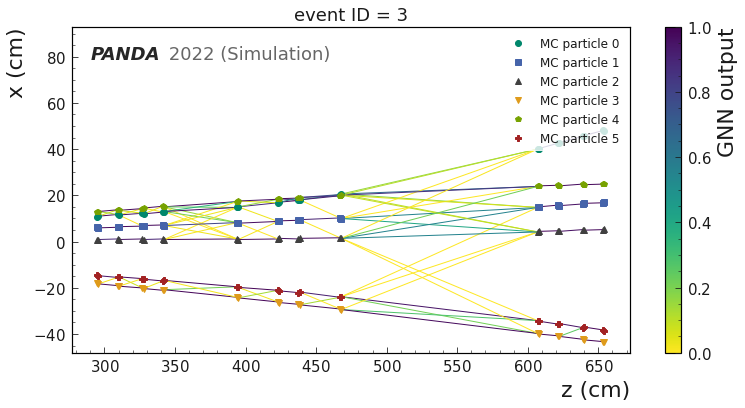

In [58]:
plot_event(hits, graph, scale=1.6).plot_graphdisplay()
plot_event(hits, graph).plot_traineddisplay(model)